In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow

In [3]:
from tqdm import tqdm
import itertools

In [4]:
import KECENI

# load data

In [5]:
data_dir = 'data'
save_dir = 'result'

In [6]:
i_sim = 0

In [7]:
data_network = pd.read_feather('%s/network.feather'%(data_dir))
data_latent = pd.read_feather('%s/latent.feather'%data_dir)
data_feature = pd.read_feather('%s/feature_%.3d.feather'%(data_dir, i_sim))

In [8]:
data_network

,row,col
0,1,244
1,2,416
2,2,536
3,2,540
4,2,726
...,...,...
3391,999,880
3392,1000,352
3393,1000,357
3394,1000,807


In [9]:
data_feature

,X1,X2,X3,p,T,m,Y
0,-1.304104,-3.400997,1.515073,0.168680,0,-0.456526,0.650450
1,1.103058,1.313203,-0.724202,0.699734,1,-0.978740,-0.873213
2,0.094427,-2.106332,-0.149959,0.253330,1,4.205473,6.069921
3,1.736643,0.747525,0.397928,0.808617,1,-4.986597,-7.219922
4,0.802826,-0.714831,0.307143,0.549232,1,2.737475,2.550342
...,...,...,...,...,...,...,...
995,-0.844635,0.142532,1.680042,0.619864,0,-2.640313,-1.525690
996,2.399211,0.477881,-0.173948,0.794387,1,-2.067055,-2.802436
997,1.431573,1.695787,-1.011341,0.742310,1,-0.761923,-1.555641
998,0.265291,2.180264,-0.299445,0.745177,1,-0.551916,-0.075563


In [10]:
n_node = len(data_latent); n_node

1000

In [11]:
len(data_network)

3396

In [12]:
Adj = sparse.csr_matrix((
    np.full(len(data_network), True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
)).toarray()

In [13]:
G = KECENI.Graph(Adj)

In [14]:
Ys = data_feature.iloc[:,6].values
Ts = data_feature.iloc[:,4].values
Xs = data_feature.iloc[:,0:3].values

In [15]:
data = KECENI.Data(Ys, Ts, Xs, G)

# hyperparameters

In [16]:
from hyperparams import delta, HyperAlpha

# counterfactual of interest

In [17]:
i0 = 17

In [18]:
T0s_1 = np.zeros(n_node); T0s_1[G.N1(i0)[::2]] = 1
T0s_0 = T0s_1.copy(); T0s_0[i0] = 0

In [19]:
T0s_0[G.N1(i0)], T0s_1[G.N1(i0)]

(array([0., 0., 1., 0., 1.]), array([1., 0., 1., 0., 1.]))

In [20]:
i0s = np.array([i0])
T0s = np.array([T0s_0, T0s_1])

# groundtruth

In [21]:
from KECENI.RegressionModel import FittedRegressionModel
from KECENI.PropensityModel import FittedPropensityModel
from KECENI.CovariateModel import FittedCovariateModel

In [22]:
from true_model import mu, pi, rX

In [24]:
true_model = KECENI.Model(
    FittedRegressionModel(mu),
    FittedPropensityModel(pi),
    FittedCovariateModel(rX),
    delta
)

In [25]:
true_fit = true_model.fit(data)

In [ ]:
result_true = true_fit.G_estimate(i0s, T0s, G, n_X=10000)

In [27]:
YTR_0, YTR_1 = result_true.reshape([2, -1])
YTR_d = YTR_1 - YTR_0

In [28]:
YTR_0, YTR_1, YTR_d

(array([-1.00912783]), array([1.01753904]), array([2.02666687]))

# estimation

In [29]:
from KECENI.RegressionModel import LinearRegressionModel
from KECENI.PropensityModel import LogisticIIDPropensityModel
from KECENI.CovariateModel import IIDCovariateModel

In [30]:
alphas_mu = np.linspace(0, 1, 11)
alphas_pi = np.linspace(0, 1, 11)

## - cross-validation

In [31]:
lamdas = np.linspace(0, 20, 21)[1:]

In [32]:
# mse_cv = np.zeros(alphas_mu.shape + alphas_pi.shape + lamdas.shape)

In [33]:
# for (i, alpha_mu), (j, alpha_pi) \
# in itertools.product(enumerate(alphas_mu), enumerate(alphas_pi)):
#     hyper_ij = HyperAlpha(alpha_mu, alpha_pi)
    
#     keceni_model = KECENI.Model(
#         LinearRegressionModel(hyper_ij.summary_mu),
#         LogisticIIDPropensityModel(hyper_ij.summary_pi),
#         IIDCovariateModel(),
#         delta
#     )
#     keceni_fit = keceni_model.fit(data)
    
#     result_cv = keceni_fit.cv(
#         tqdm=tqdm
#     )
#     xs_cv, xhs_cv = result_cv.xs_xhs(lamdas)
    
#     mse_cv[i,j] = np.mean((xs_cv-xhs_cv)**2, -1)

In [34]:
# np.save('%s/mse_cv.npy'%save_dir, mse_cv)

In [35]:
mse_cv = np.load('%s/mse_cv.npy'%save_dir)

In [36]:
id_cv = np.argmin(mse_cv.reshape(alphas_mu.shape + alphas_pi.shape + (-1,)), -1)

## - G estimate

In [38]:
result_G = np.zeros(alphas_mu.shape + alphas_pi.shape + (2,))

In [ ]:
for (i, alpha_mu), (j, alpha_pi) \
in tqdm(itertools.product(enumerate(alphas_mu), enumerate(alphas_pi)),
        total=len(alphas_mu)*len(alphas_pi), desc='G estimation'):
    hyper_ij = HyperAlpha(alpha_mu, alpha_pi)

    keceni_model = KECENI.Model(
        LinearRegressionModel(hyper_ij.summary_mu),
        LogisticIIDPropensityModel(hyper_ij.summary_pi),
        IIDCovariateModel(),
        delta
    )
    keceni_fit = keceni_model.fit(data)
    
    result_G[i,j] = keceni_fit.G_estimate(
        i0s, T0s, n_X=1000,
    )

G estimation: 100%|██████████| 121/121 [05:05<00:00,  2.53s/it]


In [40]:
YG_0, YG_1 = np.moveaxis(result_G, -1, 0)
YG_d = YG_1 - YG_0

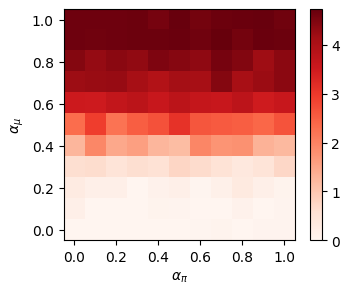

In [41]:
plt.figure(figsize=(4,3))
plt.imshow((YG_d - YTR_d)**2, 'Reds', vmin=0, origin='lower')
plt.yticks(np.arange(len(alphas_mu))[::2], labels=['%.1f'%alpha for alpha in alphas_mu[::2]])
plt.xticks(np.arange(len(alphas_pi))[::2], labels=['%.1f'%alpha for alpha in alphas_pi[::2]])
plt.xlabel(r'$\alpha_\pi$'); plt.ylabel(r'$\alpha_\mu$'); plt.colorbar()

## - KECENI

In [43]:
result_AIPW = np.zeros(alphas_mu.shape + alphas_pi.shape + lamdas.shape + (2,))

In [ ]:
for (i, alpha_mu), (j, alpha_pi) \
in tqdm(itertools.product(enumerate(alphas_mu), enumerate(alphas_pi)),
        total=len(alphas_mu)*len(alphas_pi), desc='KECENI'):
    hyper_ij = HyperAlpha(alpha_mu, alpha_pi)
    
    keceni_model = KECENI.Model(
        LinearRegressionModel(hyper_ij.summary_mu),
        LogisticIIDPropensityModel(hyper_ij.summary_pi),
        IIDCovariateModel(),
        delta
    )
    keceni_fit = keceni_model.fit(data)
    
    result_AIPW[i,j] = keceni_fit.kernel_AIPW(
        i0s, T0s
    ).est(lamdas)

KECENI:  34%|███▍      | 41/121 [02:55<05:42,  4.29s/it]

In [ ]:
YDR_0, YDR_1 = np.moveaxis(result_AIPW.reshape(
    alphas_mu.shape + alphas_pi.shape + (-1, 2)
)[np.arange(len(alphas_mu))[:,None], np.arange(len(alphas_pi)), id_cv, :], -1, 0)
YDR_d = YDR_1 - YDR_0

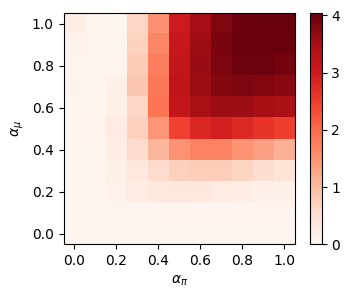

In [ ]:
plt.figure(figsize=(4,3))
plt.imshow((YDR_d - YTR_d)**2, 'Reds', vmin=0, origin='lower')
plt.yticks(np.arange(len(alphas_mu))[::2], labels=['%.1f'%alpha for alpha in alphas_mu[::2]])
plt.xticks(np.arange(len(alphas_pi))[::2], labels=['%.1f'%alpha for alpha in alphas_pi[::2]])
plt.xlabel(r'$\alpha_\pi$'); plt.ylabel(r'$\alpha_\mu$'); plt.colorbar()